Welcome to the Perfume Recommender!
To find similar perfumes, please follow these input tips:
- Use dashes (-) instead of spaces (e.g., 'poppy-barley')
- Brand names are case-insensitive (e.g., 'Le-Labo')
- Some perfumes like 'Chanel No 5' are written as 'Chanel-N05'
- Disregard any 'and's that appear in perfume or brand names (e.g., 'poppy-and-barley' becomes 'poppy-barley')



Enter the **brand** of the perfume:  le-labo
Enter the **name** of the perfume:  santal-33



Top Recommendations for 'santal-33' by Le-Labo:

| perfume                     | brand            |   Similarity |   rating_value | gender   | Main Accords                         | notes                                                                        |
|:----------------------------|:-----------------|-------------:|---------------:|:---------|:-------------------------------------|:-----------------------------------------------------------------------------|
| arche                       | mine-perfume-lab |     0.922516 |           3.97 | unisex   | woody, powdery, violet, leather      | violet, iris, leather, virginia cedar, sandalwood, papyrus, amber            |
| sand-service                | cra-yon          |     0.708236 |           3.62 | unisex   | woody, warm spicy, powdery, leather  | cardamom, violet leaf, papyrus, orris, sandalwood, cedar, leather, amber     |
| tiveden                     | zara             |     0.651698 |           4.22 | men      | warm spi

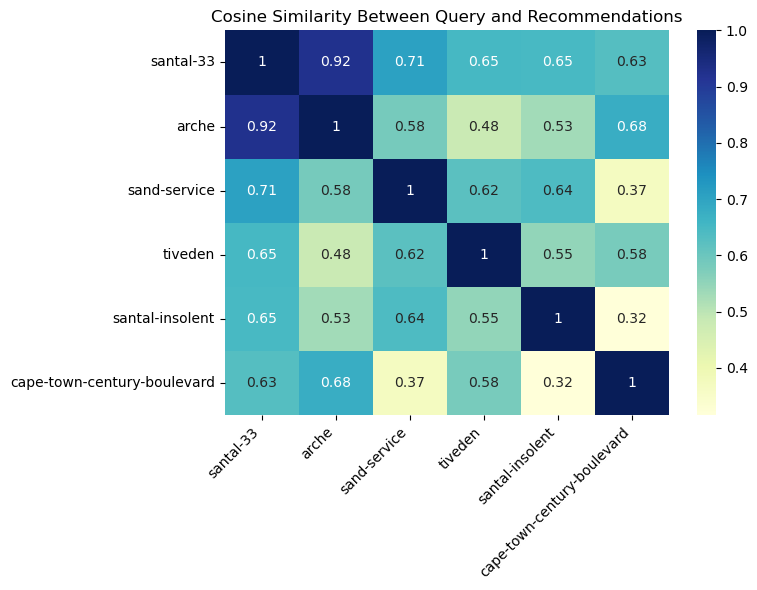

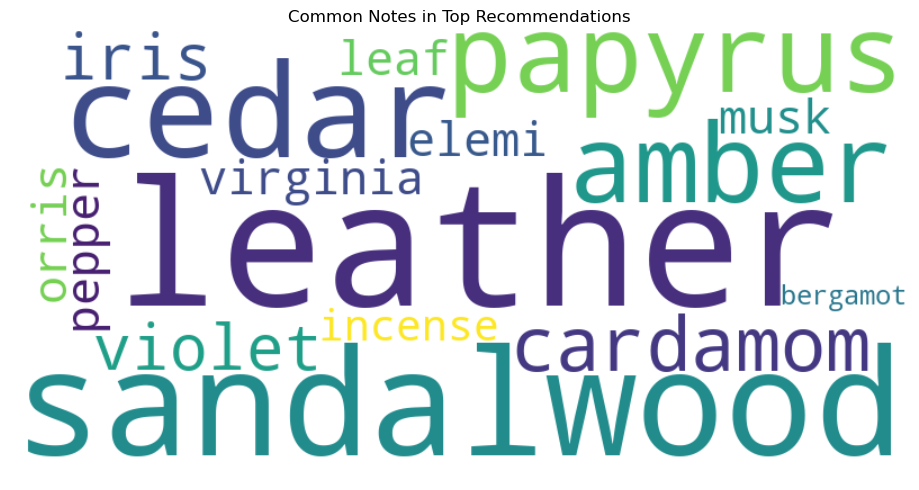

In [1]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from math import log, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# load dataset
perfumes = pd.read_csv("data/full_perfumes.csv")
perfumes = perfumes.dropna(subset=['notes', 'mainaccord1'])

# tokenize and clean
def clean_token_string(text):
    text = re.sub(r'\b(and)\b', '', text.lower())
    text = re.sub(r'-+', '-', text)
    text = re.sub(r'-$', '', text)
    text = re.sub(r'^-', '', text)
    return text.strip()

def tokenize(row):
    accords = [clean_token_string(row.get(f'mainaccord{i}', '')) for i in range(1, 5) if pd.notna(row.get(f'mainaccord{i}'))]
    notes = [clean_token_string(note) for note in row['notes'].split(',') if note.strip()]
    return accords + notes  
    
perfumes['tokens'] = perfumes.apply(tokenize, axis=1)

# vocabulary and idf
vocab = defaultdict(int)
for tokens in perfumes['tokens']:
    for token in set(tokens):
        vocab[token] += 1

total_docs = len(perfumes)
idf = {word: log(total_docs / perfume_count) for word, perfume_count in vocab.items()}

# TF-IDF vectors
def compute_tfidf(tokens, idf):
    tf = defaultdict(int)
    for token in tokens:
        tf[token] += 1
    max_tf = max(tf.values())
    return {token: (count / max_tf) * idf[token] for token, count in tf.items() if token in idf}

perfumes['tfidf'] = perfumes['tokens'].apply(lambda tokens: compute_tfidf(tokens, idf))

# cosine similarity function
def cosine_similarity(vec1, vec2):
    common = set(vec1.keys()) & set(vec2.keys())
    dot_product = sum(vec1[t] * vec2[t] for t in common)
    norm1 = sqrt(sum(v**2 for v in vec1.values()))
    norm2 = sqrt(sum(v**2 for v in vec2.values()))
    return dot_product / (norm1 * norm2) if norm1 and norm2 else 0.0

# indexing
perfumes['perfume_lower'] = perfumes['perfume'].str.lower()
perfumes['brand_lower'] = perfumes['brand'].str.lower()
perfumes['perfume_brand_key'] = perfumes['perfume_lower'] + "|" + perfumes['brand_lower']
indices = pd.Series(perfumes.index, index=perfumes['perfume_brand_key']).drop_duplicates()

# rec function
def get_recs(perfume_name, brand_name, top_n=5):
    key = f"{perfume_name.lower()}|{brand_name.lower()}"
    idx = indices.get(key)
    if idx is None:
        return None, None, None

    query_vec = perfumes.loc[idx, 'tfidf']
    query_perfume = perfumes.loc[idx, 'perfume']
    query_brand = perfumes.loc[idx, 'brand'].strip().lower()

    similarities = []
    for i, row in perfumes.iterrows():
        if i == idx or row['brand'].strip().lower() == query_brand:
            continue
        sim = cosine_similarity(query_vec, row['tfidf'])
        similarities.append((i, sim))

    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]
    top_indices = [i for i, _ in similarities]
    top_perf = perfumes.loc[top_indices].copy()
    top_perf['Similarity'] = [s for _, s in similarities]
    return query_perfume, perfumes.loc[idx], top_perf

# prompt
def prompt_user():
    print("Welcome to the Perfume Recommender!")
    print("To find similar perfumes, please follow these input tips:")
    print("- Use dashes (-) instead of spaces (e.g., 'poppy-barley')")
    print("- Brand names are case-insensitive (e.g., 'Le-Labo')")
    print("- Some perfumes like 'Chanel No 5' are written as 'Chanel-N05'")
    print("- Disregard any 'and's that appear in perfume or brand names (e.g., 'poppy-and-barley' becomes 'poppy-barley')\n")
    brand_input = input("Enter the **brand** of the perfume: ").strip().lower()
    perfume_input = input("Enter the **name** of the perfume: ").strip().lower()
    return perfume_input, brand_input

# run it all
if __name__ == "__main__":
    perfume_name, brand_name = prompt_user()
    query_perfume, query_row, top_perf = get_recs(perfume_name, brand_name)

    if top_perf is not None:
        print(f"\nTop Recommendations for '{query_perfume}' by {brand_name.title()}:\n")
        top_perf['Main Accords'] = top_perf.apply(
            lambda row: ', '.join([str(row.get(f'mainaccord{i}', '')) for i in range(1, 5) if pd.notna(row.get(f'mainaccord{i}'))]),
            axis=1)        
        print(top_perf[['perfume', 'brand', 'Similarity', 'rating_value', 'gender', 'Main Accords', 'notes']].to_markdown(index=False))

        # heatmap
        vectors = [query_row['tfidf']] + top_perf['tfidf'].tolist()
        labels = [query_perfume] + top_perf['perfume'].tolist()
        sim_matrix = np.array([[cosine_similarity(v1, v2) for v2 in vectors] for v1 in vectors])

        plt.figure(figsize=(8, 6))
        sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels, annot=True, cmap='YlGnBu')
        plt.title("Cosine Similarity Between Query and Recommendations")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # word cloud
        all_notes = ', '.join(top_perf['notes'].tolist())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_notes)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Common Notes in Top Recommendations")
        plt.tight_layout()
        plt.show()
    else:
        print("\n No perfume found. Please check spelling and try again.")
